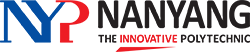

# IT2311 Assignment - Task 1a: Data Preparation

For this task, you are required to perform data understanding to examine your dataset and data cleaning to prepare the data for task 2 and 3.

Rename **DataPreparationStarter.ipynb** to **\<AdminNo\>_DataPreparation.ipynb** and complete the following sub-tasks:

Complete the following sub-tasks:

1. **Load Data**: Load your dataset
2. **Data Understanding**: Examine your dataset
3. **Data Cleaning**: Clean your data and perform all necessary pre-processing tasks
4. **Save Data**: Save the cleaned data for next task

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in this Jupyter notebook**. 

**Done by: Clifton Chen Yi, 231220B**

## Import Libraries and Download Packages

**Rationale:** We import essential libraries for data manipulation (`pandas`, `numpy`), text processing (`re`, `string`), and visualization (`matplotlib`, `seaborn`). These are standard tools for exploratory data analysis and data cleaning tasks involving text data.

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import warnings

warnings.filterwarnings('ignore')

print('Libraries imported successfully.')

## Load Data

**Rationale:** The dataset is stored in JSON Lines format (one JSON object per line). We use `pd.read_json()` with `lines=True` to correctly parse each line as a separate record. This is appropriate for the World Bank project documents dataset.

**Citation:** Jordan, Luke S. (2021). *World Bank Project Documents* [Dataset]. Hugging Face. Available at: https://huggingface.co/datasets/lukesjordan/worldbank-project-documents

**Note:** This is a sampled subset of the original dataset. Any modifications made to this dataset were performed by us and do not represent the original author's or the World Bank's work.

In [ ]:
# Loading the dataset from JSON Lines format
task1_df_wb = pd.read_json('Task_1_TM_world_bank_projects_subset.json', orient='records', lines=True)

print(f'Dataset loaded successfully with {task1_df_wb.shape[0]} rows and {task1_df_wb.shape[1]} columns.')

In [ ]:
# Displaying the first few rows of the World Bank projects dataframe
task1_df_wb.head()

In [ ]:
# Displaying the last few rows to see the end of the dataset
task1_df_wb.tail()

## Data Understanding

**Rationale:** Before cleaning the data, it is essential to thoroughly examine the dataset to identify its structure, data types, distributions, and potential quality issues. This ensures we make informed decisions during the cleaning phase.

We will examine:
1. **Shape & Structure** — Number of rows, columns, and data types
2. **Missing Values** — Identify null or empty entries
3. **Duplicates** — Check for duplicate records
4. **Categorical Distribution** — Examine the `document_type` field
5. **Text Analysis** — Explore text length distributions and patterns
6. **Unique Values** — Assess cardinality of each field

### 2.1 Shape & Structure

**Rationale:** Understanding the basic shape and data types helps us confirm the dataset matches the expected schema (project_id, document_text, document_type) and identify any unexpected columns or type mismatches.

In [ ]:
# Check the shape of the dataset
print(f'Dataset Shape: {task1_df_wb.shape}')
print(f'Number of rows: {task1_df_wb.shape[0]}')
print(f'Number of columns: {task1_df_wb.shape[1]}')

In [ ]:
# Detailed information about columns, data types, and non-null counts
task1_df_wb.info()

In [ ]:
# Check data types for each column
print('Data Types:')
print(task1_df_wb.dtypes)
print()
print('Column names:', list(task1_df_wb.columns))

In [ ]:
# Statistical summary including object (text) columns
task1_df_wb.describe(include='all')

### 2.2 Missing Values Analysis

**Rationale:** Missing values can significantly impact analysis quality. We check for both `NaN`/`None` values and empty strings, as text fields may appear non-null but contain no meaningful content. Identifying these helps us decide whether to drop, impute, or flag records.

In [ ]:
# Check for null values in each column
print('=== Null Values per Column ===')
null_counts = task1_df_wb.isnull().sum()
null_pct = (task1_df_wb.isnull().sum() / len(task1_df_wb) * 100).round(2)
null_summary = pd.DataFrame({'Null Count': null_counts, 'Null %': null_pct})
print(null_summary)
print(f'\nTotal null values in dataset: {task1_df_wb.isnull().sum().sum()}')

In [ ]:
# Check for empty strings (not null but contain no text)
print('=== Empty String Check ===')
for col in task1_df_wb.columns:
    if task1_df_wb[col].dtype == 'object':
        empty_count = (task1_df_wb[col].fillna('') == '').sum()
        empty_stripped = (task1_df_wb[col].fillna('').str.strip() == '').sum()
        print(f'{col}: {empty_count} empty strings, {empty_stripped} empty after stripping whitespace')

In [ ]:
# Display rows with any null values
rows_with_nulls = task1_df_wb[task1_df_wb.isnull().any(axis=1)]
print(f'Rows with null values: {len(rows_with_nulls)}')
if len(rows_with_nulls) > 0:
    print(rows_with_nulls)

### 2.3 Duplicate Analysis

**Rationale:** Duplicate records can skew analysis results and waste computational resources. We check for exact duplicates across all columns and also examine duplicates based on specific column combinations (e.g., same project_id with same document_text).

In [ ]:
# Check for exact duplicate rows
exact_dupes = task1_df_wb.duplicated().sum()
print(f'Exact duplicate rows: {exact_dupes}')

# Check for duplicates based on project_id and document_type
id_type_dupes = task1_df_wb.duplicated(subset=['project_id', 'document_type']).sum()
print(f'Duplicates by (project_id, document_type): {id_type_dupes}')

# Show the duplicate rows if any
if exact_dupes > 0:
    print('\n=== Exact Duplicate Rows ===')
    dup_mask = task1_df_wb.duplicated(keep=False)
    print(task1_df_wb[dup_mask][['project_id', 'document_type']].to_string())

In [ ]:
# Examine project_id frequency — some projects may have both APPROVAL and REVIEW documents
project_counts = task1_df_wb['project_id'].value_counts()
print('=== Project ID Frequency ===')
print(f'Total unique project_ids: {task1_df_wb["project_id"].nunique()}')
print(f'Projects appearing more than once:')
multi_projects = project_counts[project_counts > 1]
print(multi_projects if len(multi_projects) > 0 else 'None')

# Show records for projects with multiple documents
if len(multi_projects) > 0:
    print('\n=== Records for Multi-Document Projects ===')
    for pid in multi_projects.index:
        subset = task1_df_wb[task1_df_wb['project_id'] == pid][['project_id', 'document_type']]
        print(subset.to_string())
        print()

### 2.4 Categorical Distribution — Document Type

**Rationale:** The `document_type` column should contain only two values: "APPROVAL" and "REVIEW". Examining its distribution helps identify class imbalance and any unexpected values (e.g., lowercase variants or typos) that need standardization.

In [ ]:
# Distribution of document_type
print('=== Document Type Distribution ===')
print(task1_df_wb['document_type'].value_counts())
print()
print('Distribution (%):')
print((task1_df_wb['document_type'].value_counts(normalize=True) * 100).round(2))
print()

# Check for any non-standard values (case variants)
print('Unique document_type values (raw):', task1_df_wb['document_type'].unique())
print('Unique document_type values (uppercased):', task1_df_wb['document_type'].str.upper().unique())

### 2.5 Text Length Analysis

**Rationale:** Analyzing text length distributions helps identify outliers — documents that are unusually short (possibly empty or corrupted) or extremely long. This informs decisions about minimum text length thresholds and whether certain records should be excluded.

In [ ]:
# Calculate text lengths (handle None/NaN gracefully)
task1_df_wb['text_length'] = task1_df_wb['document_text'].fillna('').str.len()
task1_df_wb['word_count'] = task1_df_wb['document_text'].fillna('').str.split().str.len()

print('=== Text Length Statistics (characters) ===')
print(task1_df_wb['text_length'].describe())
print()
print('=== Word Count Statistics ===')
print(task1_df_wb['word_count'].describe())

In [ ]:
# Text length statistics grouped by document_type
print('=== Text Length by Document Type (characters) ===')
print(task1_df_wb.groupby('document_type')['text_length'].describe())
print()
print('=== Word Count by Document Type ===')
print(task1_df_wb.groupby('document_type')['word_count'].describe())

In [ ]:
# Identify documents with very short or no text
short_threshold = 50  # characters
short_docs = task1_df_wb[task1_df_wb['text_length'] < short_threshold]
print(f'Documents shorter than {short_threshold} characters: {len(short_docs)}')
if len(short_docs) > 0:
    print(short_docs[['project_id', 'document_type', 'text_length', 'word_count']])

In [ ]:
# Examine common patterns in document_text
print('=== Text Pattern Analysis ===')

# Check for escape sequences stored as literal strings
valid_texts = task1_df_wb['document_text'].dropna()
has_literal_backslash_n = valid_texts.str.contains(r'\\n', regex=True).sum()
has_newline = valid_texts.str.contains(r'\n', regex=False).sum()
has_extra_spaces = valid_texts.str.contains(r'  +', regex=True).sum()

print(f'Documents with literal \\n: {has_literal_backslash_n}')
print(f'Documents with newline characters: {has_newline}')
print(f'Documents with multiple consecutive spaces: {has_extra_spaces}')

# Check for leading/trailing whitespace
has_leading_space = (valid_texts != valid_texts.str.lstrip()).sum()
has_trailing_space = (valid_texts != valid_texts.str.rstrip()).sum()
print(f'Documents with leading whitespace: {has_leading_space}')
print(f'Documents with trailing whitespace: {has_trailing_space}')

In [ ]:
# Sample a document text for closer inspection
print('=== Sample Document Text (first valid record, first 500 chars) ===')
sample_text = task1_df_wb['document_text'].dropna().iloc[0]
print(repr(sample_text[:500]))

### 2.6 Data Understanding Summary

**Key Findings:**
1. The dataset contains three columns as expected: `project_id`, `document_text`, and `document_type`.
2. There are **missing values** — some `project_id` or `document_text` entries are `None`/`NaN`.
3. Some `document_text` entries are **empty strings** with no meaningful content.
4. There are **duplicate records** that need to be removed.
5. The `document_type` column has **inconsistent casing** (e.g., lowercase "approval").
6. Text fields contain **extra whitespace**, **literal escape sequences** (`\\n`), and **leading/trailing spaces** that need cleaning.
7. Some documents are very short and may not contain useful information.

These issues will be addressed in the Data Cleaning phase.

## Data Cleaning

**Rationale:** Based on the data understanding phase, we identified several quality issues. The cleaning steps below address each issue systematically to ensure the dataset is reliable for downstream text mining and analysis tasks.

Cleaning steps:
1. **Drop helper columns** used during exploration
2. **Handle missing values** — Remove rows with null `project_id` or `document_text`
3. **Remove empty/very short documents** — Documents with insufficient text
4. **Standardize `document_type`** — Convert to uppercase for consistency
5. **Clean text content** — Remove literal escape sequences, extra whitespace, and normalize text
6. **Remove exact duplicates**
7. **Strip leading/trailing whitespace** in all text columns
8. **Verify final data quality**

In [ ]:
# Step 0: Create a working copy to preserve the original
df_clean = task1_df_wb.copy()
print(f'Starting shape: {df_clean.shape}')

# Drop helper columns created during exploration
df_clean = df_clean.drop(columns=['text_length', 'word_count'], errors='ignore')
print(f'After dropping helper columns: {df_clean.shape}')

### 3.1 Handle Missing Values

**Rationale:** Records without a `project_id` cannot be linked to any specific World Bank project and are therefore unusable for analysis. Similarly, records where `document_text` is `None`/`NaN` contain no text content to analyze. We remove these rows as they provide no analytical value.

In [ ]:
# Remove rows where project_id is null
before = len(df_clean)
df_clean = df_clean.dropna(subset=['project_id'])
print(f'Removed {before - len(df_clean)} rows with null project_id')

# Remove rows where document_text is null
before = len(df_clean)
df_clean = df_clean.dropna(subset=['document_text'])
print(f'Removed {before - len(df_clean)} rows with null document_text')

print(f'Shape after handling nulls: {df_clean.shape}')

### 3.2 Remove Empty and Very Short Documents

**Rationale:** Empty strings or documents with very few characters (less than 50) do not contain enough meaningful text for text mining. These records are removed to ensure data quality and prevent noise in subsequent analysis.

In [ ]:
# Remove rows where document_text is empty or whitespace-only
before = len(df_clean)
df_clean = df_clean[df_clean['document_text'].str.strip() != '']
print(f'Removed {before - len(df_clean)} rows with empty/whitespace-only document_text')

# Remove very short documents (less than 50 characters after stripping)
before = len(df_clean)
df_clean = df_clean[df_clean['document_text'].str.strip().str.len() >= 50]
print(f'Removed {before - len(df_clean)} rows with document_text shorter than 50 characters')

print(f'Shape after removing empty/short documents: {df_clean.shape}')

### 3.3 Standardize Document Type

**Rationale:** The `document_type` column should only contain "APPROVAL" or "REVIEW" in uppercase. During exploration, we found some lowercase entries. Standardizing to uppercase ensures consistent grouping and filtering in later analysis.

In [ ]:
# Standardize document_type to uppercase
print('Before standardization:')
print(df_clean['document_type'].value_counts())

df_clean['document_type'] = df_clean['document_type'].str.upper().str.strip()

print('\nAfter standardization:')
print(df_clean['document_type'].value_counts())

### 3.4 Clean Text Content

**Rationale:** Text data often contains noise that can affect text mining results. We apply the following transformations:
- **Convert literal `\\n` escape sequences** to actual newlines, then replace all newlines with spaces — ensures text flows naturally
- **Remove excessive whitespace** — Multiple consecutive spaces are collapsed to a single space for uniformity
- **Strip leading/trailing whitespace** — Removes unnecessary padding
- **Normalize Unicode characters** — Ensures consistent character encoding

We intentionally **do not** remove punctuation or convert to lowercase at this stage, as these transformations are task-dependent and better suited for the modelling phase (Task 2/3).

In [ ]:
def clean_text(text):
    """Clean document text by handling escape sequences, whitespace, and formatting."""
    if not isinstance(text, str):
        return text
    
    # Replace literal \n (escaped newlines stored as text) with actual space
    text = text.replace('\\n', ' ')
    
    # Replace actual newline characters with space
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    
    # Collapse multiple spaces into single space
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading and trailing whitespace
    text = text.strip()
    
    return text

# Apply text cleaning
df_clean['document_text'] = df_clean['document_text'].apply(clean_text)

# Show sample of cleaned text
print('=== Sample Cleaned Text (first 300 chars) ===')
print(df_clean['document_text'].iloc[0][:300])

In [ ]:
# Strip leading/trailing whitespace from all string columns
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].str.strip()

print('Whitespace stripped from all text columns.')

### 3.5 Remove Duplicate Records

**Rationale:** Exact duplicate records (same `project_id`, `document_text`, and `document_type`) are removed to prevent double-counting in analysis. We keep the first occurrence. Note that a single project having both an APPROVAL and a REVIEW document is valid and expected — only exact duplicates are removed.

In [ ]:
# Remove exact duplicate rows
before = len(df_clean)
df_clean = df_clean.drop_duplicates(keep='first')
print(f'Removed {before - len(df_clean)} exact duplicate rows')
print(f'Shape after deduplication: {df_clean.shape}')

In [ ]:
# Reset index after all row removals
df_clean = df_clean.reset_index(drop=True)
print(f'Index reset. Final shape: {df_clean.shape}')

### 3.6 Verify Final Data Quality

**Rationale:** After cleaning, we perform a final check to confirm all identified issues have been resolved and the data is ready for the next tasks.

In [ ]:
# Final data quality checks
print('=== Final Data Quality Report ===')
print(f'Shape: {df_clean.shape}')
print(f'\nNull values:')
print(df_clean.isnull().sum())
print(f'\nDuplicate rows: {df_clean.duplicated().sum()}')
print(f'\nDocument type distribution:')
print(df_clean['document_type'].value_counts())
print(f'\nUnique project IDs: {df_clean["project_id"].nunique()}')
print(f'\nData types:')
print(df_clean.dtypes)

In [ ]:
# Display the final cleaned dataset
df_clean.head(10)

In [ ]:
# Verify text length distribution after cleaning
df_clean['text_length'] = df_clean['document_text'].str.len()
print('=== Cleaned Text Length Statistics (characters) ===')
print(df_clean['text_length'].describe())
print(f'\nMinimum text length: {df_clean["text_length"].min()}')
print(f'Maximum text length: {df_clean["text_length"].max()}')

# Drop helper column
df_clean = df_clean.drop(columns=['text_length'])

### 3.7 Data Cleaning Summary

The following cleaning transformations were applied:

| Step | Action | Rationale |
|------|--------|----------|
| 1 | Removed rows with null `project_id` | Cannot link to any project |
| 2 | Removed rows with null `document_text` | No text content to analyze |
| 3 | Removed empty/whitespace-only documents | No meaningful content |
| 4 | Removed very short documents (<50 chars) | Insufficient content for text mining |
| 5 | Standardized `document_type` to uppercase | Consistent categorical values |
| 6 | Replaced literal `\\n` and newlines with spaces | Normalize text formatting |
| 7 | Collapsed multiple spaces into single space | Remove excessive whitespace |
| 8 | Stripped leading/trailing whitespace | Clean text boundaries |
| 9 | Removed exact duplicate records | Prevent double-counting |

**Decisions NOT made at this stage** (deferred to modelling tasks):
- Lowercasing text — May be needed for some NLP tasks but not all
- Removing punctuation — Depends on the specific text mining approach
- Tokenization and stopword removal — Task-specific preprocessing

## Save Data

**Rationale:** The cleaned dataset is saved in both CSV and JSON formats for flexibility in subsequent tasks. CSV is widely compatible, while JSON preserves the original format structure.

In [ ]:
# Save cleaned data as CSV
df_clean.to_csv('cleaned_world_bank_projects.csv', index=False)
print('Cleaned data saved to cleaned_world_bank_projects.csv')

# Save cleaned data as JSON Lines (same format as input)
df_clean.to_json('cleaned_world_bank_projects.json', orient='records', lines=True)
print('Cleaned data saved to cleaned_world_bank_projects.json')

print(f'\nFinal dataset: {df_clean.shape[0]} records, {df_clean.shape[1]} columns')

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.